## Acquisition success yearly trending

To run this standalone on the HEAD or GRETA networks:
```
# Get into Ska3 environment
git clone https://github.com/sot/aca_stats.git
cd aca_stats
jupyter nbconvert --to notebook --execute acq-success-trend-yearly.ipynb
ls -lrt
```
This will create the png and csv output files.

In [1]:
import numpy as np
from agasc import get_supplement_table
%matplotlib inline
from astropy.table import Table
from mica.stats.acq_stats import get_stats
from cxotime import CxoTime
import matplotlib.pyplot as plt
from chandra_aca.star_probs import binom_ppf

In [2]:
stats = Table(get_stats())
len(stats)

290593

In [3]:
# Make truncated year column for doing grouping. If current time is less than
# half way through the year then slosh that data into the previous year.
curr_year = CxoTime.now().decimalyear
curr_year_trunc = np.trunc(curr_year)
obs_year = CxoTime(stats["guide_tstart"]).decimalyear
if curr_year - curr_year_trunc < 0.5:
    obs_year = obs_year.clip(None, curr_year_trunc - 1)
stats["iyear"] = np.trunc(obs_year)

In [4]:
# Correct ACA mags using AGASC supplement
obs_mags = get_supplement_table("mags", as_dict=True)
n_match = 0
for row in stats:
    try:
        row["mag"] = obs_mags[row["agasc_id"]]["mag_aca"]
        n_match += 1
    except KeyError:
        pass
print(n_match)

240676


In [5]:
# Select only faint stars.
# Original version of notebook filtered on stats['halfw'] >= 120 but don't do that here.
ok = (stats["mag"] >= 9.6) & (stats["mag"] < 10.6)
sok = stats[ok]

In [6]:
len(sok)

68218

In [7]:
n_match

240676

In [8]:
sok["imag"] = np.trunc(sok["mag"] * 5) / 5

In [9]:
sg = sok.group_by(keys=["imag", "iyear"])["imag", "iyear", "star_tracked"]

In [10]:
len(sg.groups)

110

In [20]:
rows = []
for grp in sg.groups:
    n_tracked = np.sum(grp["star_tracked"])
    n_obs = len(grp)
    f_track = n_tracked / n_obs
    err_m, err_p = binom_ppf(n_tracked, n_obs, [0.16, 0.84]) - f_track
    row = (
        grp["imag"][0],
        grp["iyear"][0],
        n_tracked,
        n_obs,
        f_track.round(3),
        err_m.round(4),
        err_p.round(4),
    )
    rows.append(row)
sga = Table(
    rows=rows,
    names=["imag", "iyear", "n_tracked", "n_obs", "frac_tracked", "err_m", "err_p"],
)

In [21]:
sga

imag,iyear,n_tracked,n_obs,frac_tracked,err_m,err_p
float64,float64,int64,int64,float64,float64,float64
9.6,2002.0,512,523,0.979,-0.0087,0.0041
9.6,2003.0,920,935,0.984,-0.0057,0.0027
9.6,2004.0,802,814,0.985,-0.006,0.0026
9.6,2005.0,906,916,0.989,-0.0051,0.002
9.6,2006.0,908,936,0.97,-0.0071,0.0041
9.6,2007.0,947,972,0.974,-0.0066,0.0036
9.6,2008.0,980,993,0.987,-0.0052,0.0022
9.6,2009.0,1088,1103,0.986,-0.0049,0.0022
9.6,2010.0,1053,1073,0.981,-0.0056,0.0028


In [13]:
# The mean of the star_tracked 0's and 1's is the tracking fraction.
# sga = sg.groups.aggregate(np.mean)

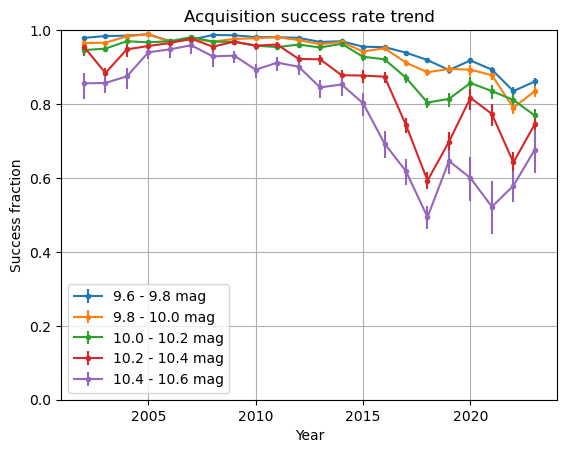

In [25]:
# Make the plot
fig, ax = plt.subplots()
imags = sorted(set(sga["imag"]))
for imag in imags:
    ok = sga["imag"] == imag
    ax.errorbar(
        sga["iyear"][ok],
        sga["frac_tracked"][ok],
        yerr=[-sga["err_m"][ok], sga["err_p"][ok]],
        fmt="-o",
        ms=3,
        label=f"{imag:.1f} - {imag+0.2:.1f} mag",
    )
ax.legend()
ax.grid()
ax.set_title("Acquisition success rate trend")
ax.set_ylabel("Success fraction")
ax.set_xlabel("Year")
ax.set_ylim(0, 1)
plt.savefig("acq_success_yearly.png", dpi=150)

In [16]:
sga.write("acq_success_yearly.csv", overwrite=True)